In [1]:
from common_imports import *
from helper import *

# To plot pretty figures
%matplotlib widget

Using TensorFlow backend.


1.13.1


## Half the data will be split out as validation and 0.2 as the test set

In [4]:

def get_split_index(features, labels, test_size=0.2):
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, original_labels, training_labels):
    train_index, validation_index = get_split_index(features, original_labels, test_size=0.5)[0]
    
    X_valid, y_valid, y_valid_original = features.iloc[validation_index],  training_labels.iloc[validation_index], original_labels.iloc[validation_index]
    X_train, y_train, y_original = features.iloc[train_index], training_labels.iloc[train_index], original_labels.iloc[train_index]
     
    return X_train, y_train, y_original, X_valid, y_valid, y_valid_original

def get_train_test_val(features, original_labels, training_labels):
    
    X, y, y_original, X_valid, y_valid, y_valid_original = split_valid(features,original_labels, training_labels)
   
    train_index, test_index = get_split_index(X, y_original)[0]
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

    return X_train, y_train, X_test, y_test, y_original, X_valid, y_valid, y_valid_original

### Train a DNN on the modified dataset

Creating data...


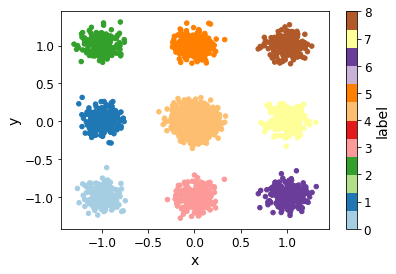

Train Size: (1600, 2)
Test Size: (400,)
Categories: [array([0, 1])]


In [5]:
# Get split returns a generator
# List comprehension is one way to evaluate a generator

original_data, modded_samples, training_labels, original_labels = simulate_blobs(class_size=2000)

# Separating a hold out set that will be used for validation later
X_train, y_train, X_test, y_test, y_original, X_valid, y_valid, y_valid_original = get_train_test_val(modded_samples, original_labels, training_labels)


print("Train Size:", X_train.shape)
print("Test Size:", y_test.shape)


hot_encoder = dfHotEncoder()
hot_encoder.fit(training_labels)
print("Categories:", hot_encoder.categories_)

In [6]:
NUM_FEATURES = X_train.shape[1]
NUM_LABELS = len(hot_encoder.categories_[0])

In [7]:
def build_dnn(num_features, num_labels=3):

#     reset_graph()
    
    keras.backend.clear_session()

    nn = keras.models.Sequential()
    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = tf.keras.initializers.he_uniform()
    
    nn.add(Dense(units = 16, activation="elu", input_dim=num_features,
                kernel_initializer=he_init))
    nn.add(Dense(units = 16, activation="elu",
                kernel_initializer=he_init))
#     nn.add(Dense(units = 16, activation="elu",
#                 kernel_initializer=he_init))
    nn.add(Dense(units=2, activation= "softmax",
                kernel_initializer=he_init))

#     BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    nn.compile(loss="categorical_crossentropy",
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    return nn

def train_model(model, X, y, X_test=[], y_test=[], epochs=30, batch_size=20, verbose=1, plot=True):
    
    ZScaler = StandardScaler().fit(X)
    
    X_train = ZScaler.transform(X)
    X_test = ZScaler.transform(X_test)
    
    y_train = hot_encoder.transform(y)
    y_test = hot_encoder.transform(y_test)
    
#     lr_scheduler = keras.callbacks.LearningRateScheduler(exp_decay)
    callback_list = []
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size,
                        validation_data=(X_test, y_test), callbacks=callback_list, verbose=verbose)
    
#     if plot: plot_history(history)
    
    return history, ZScaler


In [8]:
nn = build_dnn(NUM_FEATURES)
%time history, Zscaler = train_model(nn, X_train, y_train, X_test, y_test, epochs=50, batch_size=20)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 1600 samples, validate on 400 samples
Epoch 1/50
1600/1600 [==============================] - 0s 151us/step - loss: 0.5330 - acc: 0.8044 - val_loss: 0.3214 - val_acc: 1.0000
Epoch 2/50
1600/1600 [==============================] - 0s 35us/step - loss: 0.2464 - acc: 1.0000 - val_loss: 0.1845 - val_acc: 1.0000
Epoch 3/50
1600/1600 [==============================] - 0s 36us/step - loss: 0.1505 - acc: 1.0000 - val_loss: 0.1195 - val_acc: 1.0000
Epoch 4/50
1600/1600 [==============================] - 0s 38us/step - loss: 0.1018 - acc: 1.0000 - val_loss: 0.0839 - val_acc: 1.0000
Epoch 5/50
1600/1600 [==============================] - 0s 41us/step - loss: 0.0741 - acc: 1.0000 - val_loss: 0.0628 - val_acc: 1.0000
Epoch 6/50
1600/1600 [==============================] - 0s 37us/step - loss: 0.0569 - acc: 1.0000 - val_loss: 0.0491 - val_acc: 1.0000
Epoch 7/50
1600/1600 [

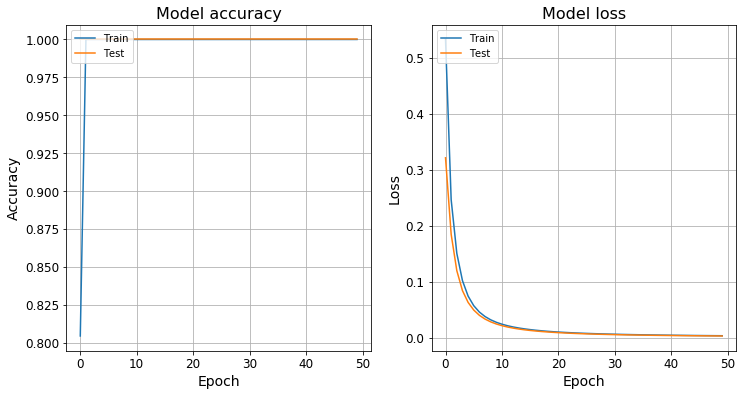

In [9]:
# Plotting results from history
plot_history(history)

In [10]:
preds = [x for x in nn.predict(Zscaler.transform(X_test[:5]))]
_labels = [np.float(x) for x in y_test]
preds[:5],_labels[:5]

([array([0.00133092, 0.99866915], dtype=float32),
  array([0.9950211 , 0.00497894], dtype=float32),
  array([0.00139786, 0.9986021 ], dtype=float32),
  array([9.9989128e-01, 1.0870953e-04], dtype=float32),
  array([0.99732333, 0.00267667], dtype=float32)],
 [1.0, 0.0, 1.0, 0.0, 0.0])

## Performing LRP

In [11]:
import innvestigate
import innvestigate.utils as iutils

def perform_analysis(model, analyzer, data, labels=[]):
    analysis = analyzer.analyze(data)
    prediction = model.predict(data)
    
    df_anal = pd.DataFrame(analysis)
    
    return df_anal


scaled_samples = Zscaler.transform(X_valid)

# Getting all the samples that can be correctly predicted
all_samples, _labels, correct_idxs = getCorrectPredictions(nn, scaled_samples, y_valid, enc = hot_encoder)
all_labels = y_valid_original[correct_idxs]


# Stripping the softmax activation from the model
model_w_softmax = nn
model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

# Creating an analyzer
lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)
lrp_Z = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPZPlus(model=model)
lrp_AB   = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPAlpha2Beta1(model=model)



# perform_analysis(nn,gradient_analyzer,flowers,types)
all_lrp_AB = perform_analysis(model,lrp_AB, all_samples)
all_lrp_E = perform_analysis(model,lrp_E, all_samples)
all_lrp_Z = perform_analysis(model,lrp_Z, all_samples)


Prediction Accuracy
2000/2000 [==============================] - 0s 10us/step
Scores on data set: loss=0.003 accuracy=1.0000
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [12]:
all_labels.value_counts()

4    1000
8     125
7     125
6     125
5     125
3     125
2     125
1     125
0     125
Name: label, dtype: int64

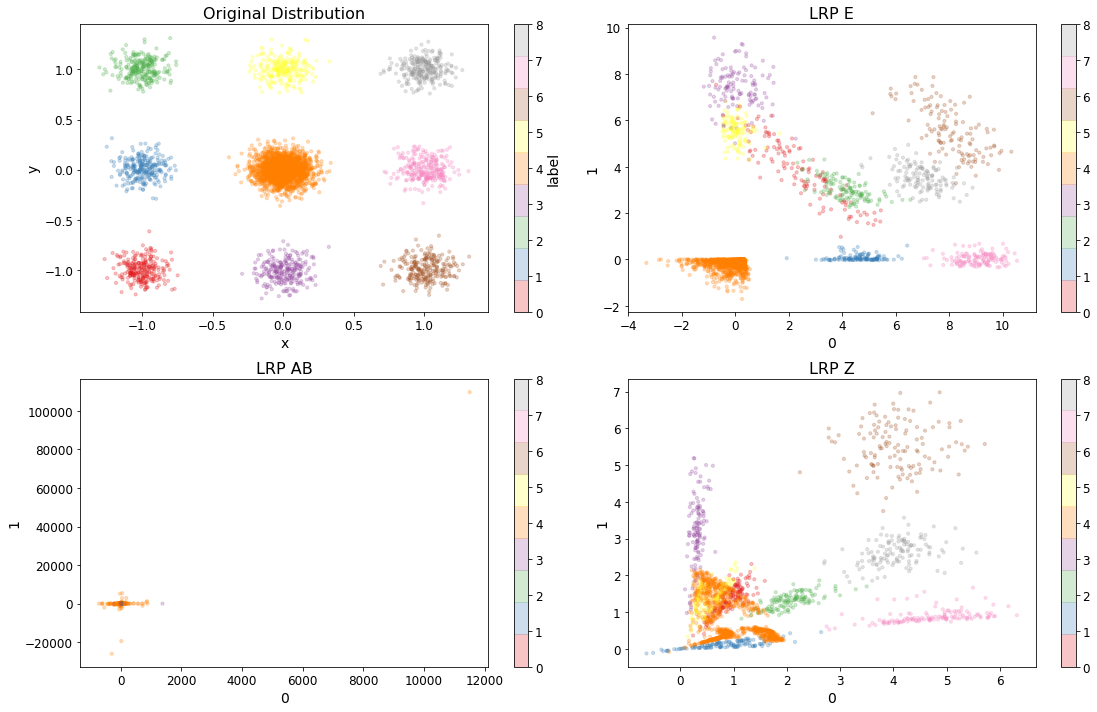

In [13]:
plt.close("Comparison")
fig, axs = plt.subplots(2,2, figsize=(16,10), num="Comparison")
cmap = "Set1" #"Paired"
plot_args = {"kind":"scatter", "x":0,  "y":1, "c":"label", "cmap": cmap, "s":10, "alpha":0.25}

original_data.plot(ax=axs[0][0],title="Original Distribution", **plot_args)

plot_args["c"] = all_labels
all_lrp_E.plot(ax=axs[0][1], title="LRP E", **plot_args)

all_lrp_AB.plot(ax=axs[1][0], title="LRP AB", **plot_args)
all_lrp_Z.plot(ax=axs[1][1], title="LRP Z", **plot_args)

plt.tight_layout()
plt.show()
# plt.savefig(figures_dir+"multiclass_lrp.png")

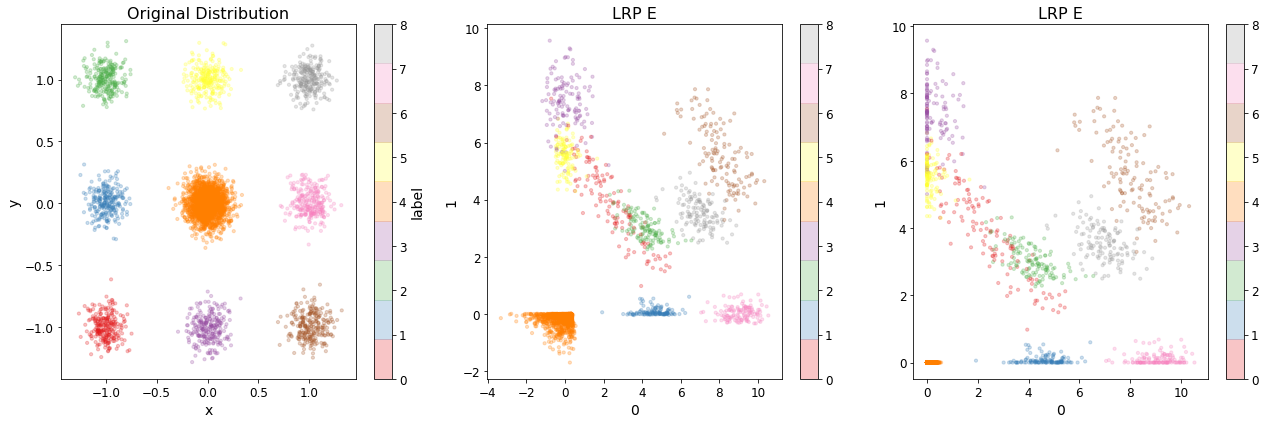

In [14]:
plt.close("Positive Only LRP")
fig, axs = plt.subplots(1,3, figsize=(18,6), num="Positive Only LRP")

plot_args["c"] = "label"
original_data.plot(ax=axs[0], title="Original Distribution", **plot_args)

plot_args["c"] = all_labels
all_lrp_E.plot(ax=axs[1], title="LRP E", **plot_args)

pos_lrp = all_lrp_E.copy()
pos_lrp[pos_lrp<0] = 0
pos_lrp["label"] = all_labels.values
pos_lrp.plot(ax=axs[2],title="LRP E", **plot_args)

plt.tight_layout()
plt.show()

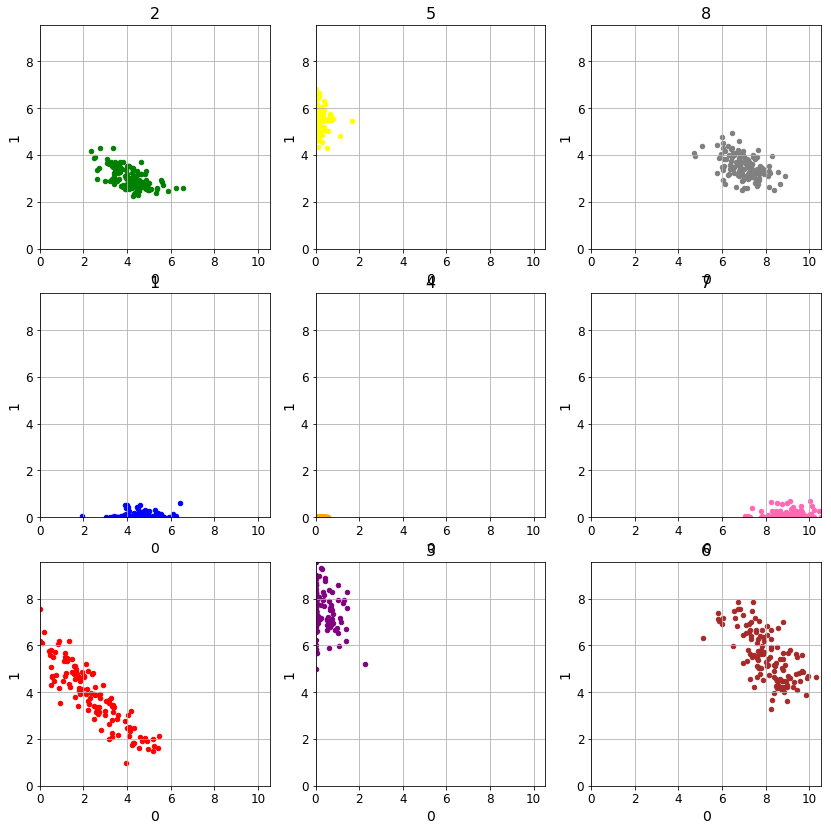

In [15]:
plotSeparatedLRP(pos_lrp)

# Beginning Clustering using accelerated HDBSCAN*

In [16]:
import hdbscan
import seaborn as sns
%matplotlib widget
# sns.set_context('poster')
# sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [17]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=25)
clusterer.fit(pos_lrp)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=25, min_samples=None, p=None,
    prediction_data=False)

In [18]:
clusterer.labels_.max()

11

In [19]:
plt.close("Dendogram")
fig, axs = plt.subplots(1, figsize=(18,8), num="Dendogram")
clusterer.condensed_tree_.plot(select_clusters=True, log_size=True,)

FigureCanvasNbAgg()

/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/hdbscan/plots.py:383: UserWarning: Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.
  warn('Infinite lambda values encountered in chosen clusters.'


In [20]:
data = pos_lrp[[0,1]].values
clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
clusterer.fit(data)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=15, min_samples=None, p=None,
    prediction_data=False)

In [21]:
num_clusters = clusterer.labels_.max()
cluster_labels = pd.Series(clusterer.labels_)
cluster_labels.value_counts()

 2     546
-1     386
 6     180
 11    154
 0     124
 1     123
 9     106
 13     99
 10     64
 3      53
 12     51
 8      43
 5      28
 7      27
 4      16
dtype: int64

In [22]:
plt.close("Clusters")
fig, axs = plt.subplots(1, figsize=(20,10), num="Clusters")
color_palette = sns.color_palette('deep', num_clusters+1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

FigureCanvasNbAgg()

In [23]:
# plt.savefig(figures_dir+"clusters_elu.png")

In [24]:
plt.close("Colored Clusters")
fig, axs = plt.subplots(1, figsize=(18,10), num="Colored Clusters")
color_palette = sns.color_palette("bright", num_clusters+1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0, 0, 0)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.6)

FigureCanvasNbAgg()

In [25]:
# plt.savefig(figures_dir+"clusters_desaturated.png")

# Scoring Clustering Performance

In [26]:
from sklearn import metrics

In [32]:
## Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
noise = list(cluster_labels).count(-1)/len(cluster_labels) * 100

hscore,cscore,vscore = metrics.homogeneity_completeness_v_measure(y_valid_original, cluster_labels)
sil_score = metrics.silhouette_score(data, cluster_labels, metric="euclidean")

print("Noise: {:7}{:.2f}%".format("",noise))
print("Homogeneity:  {:.3f}\nCompleteness: {:.3f}\nV-Measure:    {:.3f}".format(hscore, cscore, vscore))
print("Silhouette: {:2}{:.3f}".format("",sil_score))

Noise:        19.30%
Homogeneity:  0.751
Completeness: 0.573
V-Measure:    0.650
Silhouette:   0.467


In [33]:
hscore_orig,cscore_orig,vscore_orig = metrics.homogeneity_completeness_v_measure(y_valid_original, y_valid_original)
sil_score_orig = metrics.silhouette_score(data, y_valid_original, metric="euclidean")

print("Homogeneity:  {:.3f}\nCompleteness: {:.3f}\nV-Measure:    {:.3f}".format(hscore_orig, cscore_orig, vscore_orig))
print("Silhouette: {:2}{:.3f}".format("",sil_score_orig))

Homogeneity:  1.000
Completeness: 1.000
V-Measure:    1.000
Silhouette:   0.709


In [36]:
1-(sil_score/sil_score_orig)

0.3421238660812378